# Note book to count all the detected objects

In [34]:
%matplotlib inline
import os 
import matplotlib
import collections
import itertools
from os import makedirs, path as op
import json 
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook", font_scale=1.5)
sns.set_style("darkgrid")
# from utils_csv_manupilation import read_big_csv, _filter_values, aggregate_classes

In [15]:
# %%file post_processing/utils_csv_manupilation.py


def read_big_csv(csv, columns=None):
    """filter and rename tractory csv files
    
    Args:
        csv: csv file that contains gps coordination 
        
    Returns:
        df: exported dataframe filtered columns and renamed
    """
    # csv is more than 500MB, so read data in chunks e.g. 5000 rows per chunk
    c_size = 5000
    if columns:
        select_cols = ['HEADING', 'IMAGE_ID', 'LAT', 'LONG']
        df_chunks_lst = [chuck_df for chuck_df in pd.read_csv(csv, 
                                    chunksize=c_size, skipinitialspace=True, usecols=select_cols)]
    else:
        df_chunks_lst = [chuck_df for chuck_df in pd.read_csv(csv, 
                                    chunksize=c_size, skipinitialspace=True)]
    
    df = pd.concat(df_chunks_lst)
    return df


def _filter_values(values, optimal_score):
    """filter detection by the optimal score
    
    Args:
        detection: the detection for each images
    Returns:
        new
    """
    values = ast.literal_eval(values)
    new_dict = dict(detection_scores=[],
       detection_classes =[],
       detection_boxes = [], 
                   image_fname=None)
    for detection in values:
        if float(detection['detection_scores'])>= float(optimal_score[int(detection['detection_classes'])]):
            new_dict['detection_scores'].append(detection['detection_scores'])
            new_dict['detection_classes'].append(int(detection['detection_classes']))
            new_dict['detection_boxes'].append(detection['detection_boxes'])
    return new_dict


def filter_detection_by_optimal_score(optimal_score, df, output_dir, col = ['tile', 'output']):
    """filter dataframe values by the given threshold
    
    Args:
        optimal_score: dictionary include the optimal key and value;
        df: the target dataframe
    
    Returns:
        (None): write each row into json file
    """
    df2dict = dict(zip(df[col[0]], df[col[1]]))
    for key, value in df2dict.items():
        new_dict = _filter_values(value, optimal_score)
        new_dict['image_fname']=key
        if not op.isdir(output_dir):
            makedirs(output_dir)
        nm = op.splitext(op.basename(key))[0]
        out_file = op.join(output_dir, f"{nm}.json")
        if op.isfile(out_file):
            continue
        else:
            with open(out_file, 'w') as f:
                json.dump(new_dict, f)
                
def aggregate_classes(optimal_score, df, col = ['tile', 'output']):
    """filter dataframe values by the given threshold
    
    Args:
        optimal_score: dictionary include the optimal key and value;
        df: the target dataframe
    
    Returns:
        (None): write each row into json file
    """
    all_cls = []
    df2dict = dict(zip(df[col[0]], df[col[1]]))
    for key, value in df2dict.items():
        new_dict = _filter_values(value, optimal_score)
        all_cls.append(new_dict['detection_classes'])
        
    # get all the detected classes and count the frequency 
    freq = collections.defaultdict(int)
    for x in itertools.chain.from_iterable(all_cls):
        freq[x] +=1
        
    return dict(freq)



In [6]:
b_parts = "results-padang-building-parts.csv"
b_properties = "results-padang-building-properties.csv"
model_stats = 'model_evaluation_hp_padang_raw.csv'

In [12]:
df_b_parts = read_big_csv(b_parts)
filter_dict_parts = {1:0.5, 2:0.5, 3:0.5, 4:0.5}

In [ ]:
b_parts_detection_counts = aggregate_classes(filter_dict_parts, df_b_parts, col = ['tile', 'output'])

In [16]:
b_parts_detection_counts

{1: 987578, 3: 244853, 2: 191787, 4: 1015}

In [ ]:
df_parts_counts = pd.DataFrame.from_dict(b_parts_detection_counts, orient='index', columns=['counts'])
df_parts_counts['class_name'] = ['window', 'door', 'garage', 'disaster_mitigation']
df_parts_counts

Total detected objects: 1425233
window: 987578
door: 244853
garage: 191787
disaster_mitigation: 1015


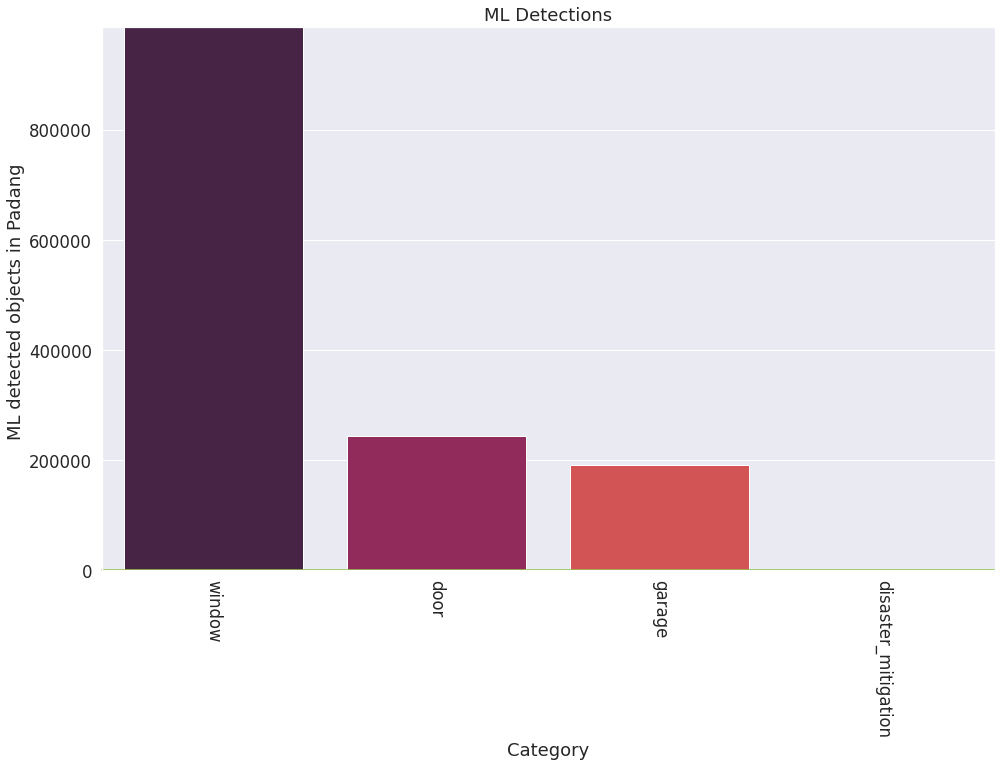

In [50]:
# Plot performance for all categories
fig, ax = plt.subplots(figsize=(16, 10))

sort_df = df_parts_counts.sort_values(by='counts', ascending=False)
x_names = list(sort_df['class_name'])
y_vals = list(sort_df['counts'])


_ = sns.barplot(x=x_names, y=y_vals, palette="rocket", ax=ax)

# Print out the raw performance data
print(f'Total detected objects: {sum(y_vals)}' )
for x_name, y_val in zip(x_names, y_vals):
    print(f'{x_name}: {y_val}')


current_palette = matplotlib.colors.hex2color('#86b92e')

ax.axhline(0, color=current_palette, clip_on=False)
ax.set_ylim([0, max(sort_df['counts'])])
ax.set_ylabel("ML detected objects in Padang ")
ax.set_xlabel("Category")
ax.set_title("ML Detections")
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=270)

In [ ]:
df_model = pd.read_csv(model_stats)
df_model = df_model.sort_values(by='threshold score', ascending=False)
df_model

In [39]:
cls_map = dict(zip(df_model['cls_id'], df_model['threshold score']))

In [40]:
df_b_properties = read_big_csv(b_properties)

In [41]:
b_properties_detection_counts = aggregate_classes(cls_map, df_b_properties, col = ['tile', 'output'])

In [ ]:
b_properties_detection_counts

In [ ]:
b_properties_detection_counts.keys()

In [ ]:
missing_cls = [5, 7, 8, 9]
df_model['detected_properties_count'] = df_model['cls_id'].apply(lambda x: b_properties_detection_counts[x] if x in b_properties_detection_counts.keys() else 0)
df_model

Total detected objects: 4730918
complete: 734346
fair: 722392
confined_masonry-concrete_frame: 680019
residential: 605121
plaster: 563990
poor: 365456
mix-other-unclear: 297840
commercial: 177378
critical_infrastructure: 145468
good: 97553
timber_wooden_frame: 83608
mixed: 65934
brick_or_cement-concrete_block: 62276
incomplete: 31324
wood_crude-plank: 30602
wood_polished: 21788
other: 20415
corrugated_metal: 15245
unreinforced_masonry: 10163
plant_material: 0
container-trailer: 0
stone_with_mud-ashlar_with_lime_or_cement: 0
adobe: 0


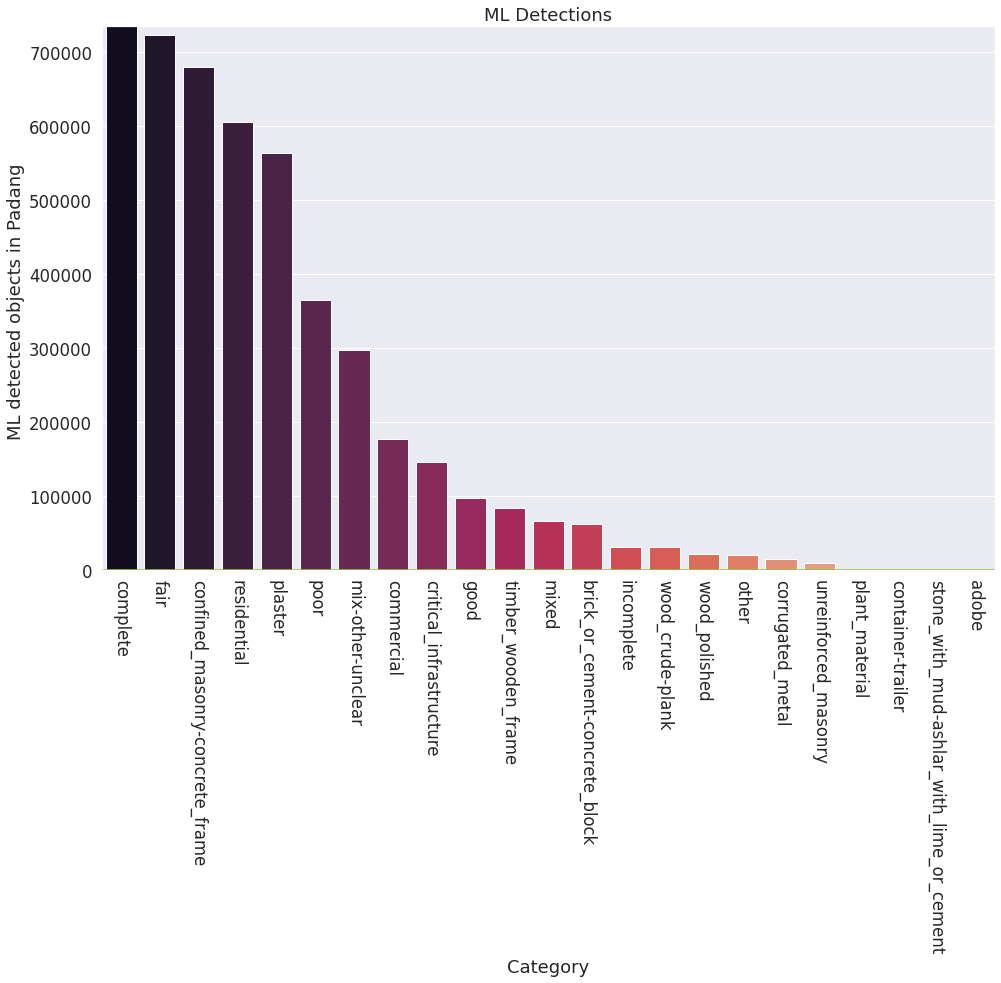

In [52]:
# Plot performance for all categories
fig, ax = plt.subplots(figsize=(16, 10))

sort_df = df_model.sort_values(by='detected_properties_count', ascending=False)
x_names = list(sort_df['class'])
y_vals = list(sort_df['detected_properties_count'])


_ = sns.barplot(x=x_names, y=y_vals, palette="rocket", ax=ax)

# Print out the raw performance data
print(f'Total detected objects: {sum(y_vals)}' )
for x_name, y_val in zip(x_names, y_vals):
    print(f'{x_name}: {y_val}')


current_palette = matplotlib.colors.hex2color('#86b92e')

ax.axhline(0, color=current_palette, clip_on=False)
ax.set_ylim([0, max(sort_df['detected_properties_count'])])
ax.set_ylabel("ML detected objects in Padang ")
ax.set_xlabel("Category")
ax.set_title("ML Detections")
_ = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=270)